<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/Image_classification_with_EANet_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image classification with EANet (External Attention Transformer)**

**This example implements the EANet model for image classification, and demonstrates it on the CIFAR-100 dataset. EANet introduces a novel attention mechanism named external attention, based on two external, small, learnable, and shared memories, which can be implemented easily by simply using two cascaded linear layers and two normalization layers. It conveniently replaces self-attention as used in existing architectures. External attention has linear complexity, as it only implicitly considers the correlations between all samples.**

In [1]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 12.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras import layers

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
num_classes = 100
input_shape = (32, 32, 3)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169001437/169001437 [==============================] - 14s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 100)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 100)


In [4]:
weight_decay = 0.0001
learning_rate = 0.001
label_smoothing = 0.1
validation_split = 0.2
batch_size = 128
num_epochs = 50
patch_size = 2  # Size of the patches to be extracted from the input images.
num_patches = (input_shape[0] // patch_size) ** 2  # Number of patch
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 4
num_heads = 4
attention_dropout = 0.2
projection_dropout = 0.2
num_transformer_blocks = 8  # Number of repetitions of the transformer layer

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")

Patch size: 2 X 2 = 4 
Patches per image: 256


In [5]:
data_augmentation = keras.Sequential([
    layers.Normalization(),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(factor = 0.1),
    layers.RandomContrast(factor = 0.1),
    layers.RandomZoom(height_factor = 0.2, width_factor = 0.2)
    ], name = "data_augmentation")

data_augmentation.layers[0].adapt(x_train)

**Implement the patch extraction and encoding layer**

In [6]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size, self.patch_size, 1),
            strides=(1, self.patch_size, self.patch_size, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)

**Implement the external attention block**

In [7]:
def external_attention(
    x, dim, num_heads, dim_coefficient=4, attention_dropout=0, projection_dropout=0
):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = tf.reshape(x, shape=(-1, num_patch, num_heads, dim * dim_coefficient // num_heads))
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = attn / (1e-9 + tf.reduce_sum(attn, axis=-1, keepdims=True))
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    x = tf.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x

**Implement the MLP block**

In [8]:
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Dense(mlp_dim, activation=tf.nn.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x

**Implement the Transformer block**

In [9]:
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim, dropout=attention_dropout
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x

***Implement the EANet model***

The EANet model leverages external attention. The computational complexity of traditional self attention is O(d * N ** 2), where d is the embedding size, and N is the number of patch. the authors find that most pixels are closely related to just a few other pixels, and an N-to-N attention matrix may be redundant. So, they propose as an alternative an external attention module where the computational complexity of external attention is O(d * S * N). As d and S are hyper-parameters, the proposed algorithm is linear in the number of pixels. In fact, this is equivalent to a drop patch operation, because a lot of information contained in a patch in an image is redundant and unimportant.

In [10]:
def get_model(attention_type="external_attention"):
    inputs = layers.Input(shape=input_shape)
    # Image augment
    x = data_augmentation(inputs)
    # Extract patches.
    x = PatchExtract(patch_size)(x)
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
        )

    x = layers.GlobalAvgPool1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [11]:
model = get_model(attention_type="external_attention")

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=validation_split)

Epoch 1/50
313/313 [==============================] - 99s 269ms/step - loss: 4.3182 - accuracy: 0.0551 - top-5-accuracy: 0.1935 - val_loss: 4.5586 - val_accuracy: 0.0670 - val_top-5-accuracy: 0.2163
Epoch 2/50
313/313 [==============================] - 84s 268ms/step - loss: 4.0202 - accuracy: 0.1020 - top-5-accuracy: 0.3077 - val_loss: 4.6457 - val_accuracy: 0.0830 - val_top-5-accuracy: 0.2500
Epoch 3/50
313/313 [==============================] - 84s 267ms/step - loss: 3.8558 - accuracy: 0.1369 - top-5-accuracy: 0.3675 - val_loss: 5.0717 - val_accuracy: 0.0794 - val_top-5-accuracy: 0.2562
Epoch 4/50
313/313 [==============================] - 85s 270ms/step - loss: 3.7523 - accuracy: 0.1567 - top-5-accuracy: 0.4094 - val_loss: 5.1343 - val_accuracy: 0.0867 - val_top-5-accuracy: 0.2642
Epoch 5/50
313/313 [==============================] - 82s 261ms/step - loss: 3.6610 - accuracy: 0.1784 - top-5-accuracy: 0.4390 - val_loss: 4.9599 - val_accuracy: 0.1034 - val_top-5-accuracy: 0.2763
Epoch

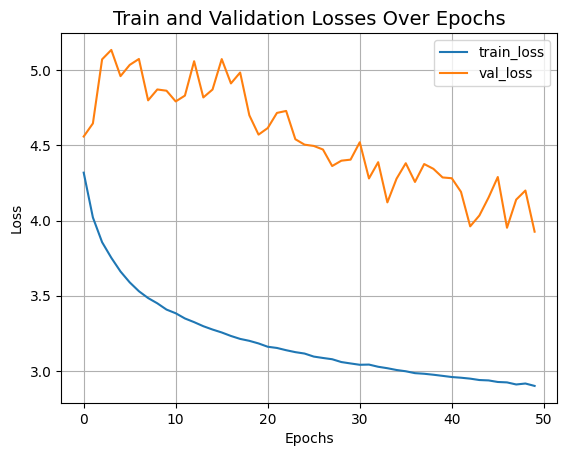

In [12]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [13]:
loss, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

313/313 [==============================] - 12s 39ms/step - loss: 3.8807 - accuracy: 0.2063 - top-5-accuracy: 0.4720
Test loss: 3.88
Test accuracy: 20.63%
Test top 5 accuracy: 47.2%


**EANet just replaces self attention in Vit with external attention. The traditional Vit achieved a ~73% test top-5 accuracy and ~41 top-1 accuracy after training 50 epochs, but with 0.6M parameters. Under the same experimental environment and the same hyperparameters, The EANet model we just trained has just 0.3M parameters, and it gets us to ~73% test top-5 accuracy and ~43% top-1 accuracy. This fully demonstrates the effectiveness of external attention. We only show the training process of EANet, you can train Vit under the same experimental conditions and observe the test results.**